In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from PIL import Image
from scipy.stats import logistic


# Name of the hdf file that contain the data we need
f_name = 'sxro6416-r0504.h5'

# Open the hdf5 file, use the path to the images to extrate the data and place
# it in the image data object for further manipulation and inspection.
datafile = h5py.File(f_name, 'r')
image_data = []
for i in itertools.count(start=0):
    d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
    if d is not None:
        # actual image is at first index
        image_data.append(d[0])
    else:
        break

#print(image_data[1])
# Tell me how many images were contained in the datafile
print(f"loaded {len(image_data)} images")


#for i in range(20):
    #plt.imshow(image_data[i])
    #plt.savefig('image'+str(i)+'.png',dpi=1000)
    #image = Image.fromarray(image_data[i]).convert("L")
    #image.save("image"+str(i)+".png")

# Plot a good dataset - here index 8 (but there are others too!)
#misc.imshow(image_data[0])
#misc.show()

#image = Image.fromarray(image_data[0]).convert("L")
#image.save("out.png")

# The histogram of the data will help show possible single photon hits
plt.hist(image_data[1].flatten(), bins=100)
plt.yscale('log')


loaded 20 images


In [4]:
dat=image_data[1]
dat.shape

(2048, 2048)

In [15]:
#This is a test program. All codes will be run on this test data, extracted from image #1.
test_dat=dat[242:262,1246:1288].astype(int)-50
test_dat_2=dat[492:525,1308:1340].astype(int)-50
test_height_2=test_dat_2.shape[0]
test_width_2=test_dat_2.shape[1]
test_height=test_dat.shape[0]
test_width=test_dat.shape[1]
print(test_height,test_width)

20 42


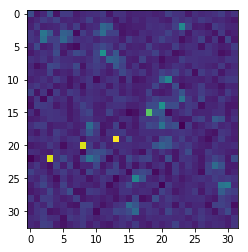

In [16]:
plt.imshow(test_dat_2)
#test_dat

In [17]:
### Define the distribution function of single photon events.

#Here, such distribution is modeled as Gaussian. Later this will be justified/replaced with more justified forms based on
#literatures and/or physical simulations

def dist_f_gaussian(x,y,x0,y0,s1,s2,A,t,cutoff=2):
    x1=(x-x0)*np.cos(t)-(y-y0)*np.sin(t)
    y1=(x-x0)*np.sin(t)+(y-y0)*np.cos(t)
    #print(x1,y1,x0,y0,s1,s2,A,t,cutoff)
    if(x1>=cutoff*s1 or y1>=cutoff*s2):
        return 0
    else:
        return A/s1/s2*np.exp(-x1**2/(2*s1**2)-y1**2/(2*s2**2))

#With respect to this distribution, we create a class of single photon events(SPE):
from scipy.integrate import simps
import math

class gaussian_spe:
    'A distribution of intensity caused by a single photon event'
    
    intensity_matrix=np.zeros((test_height,test_width))
    
    dist_fn='gaussian'
    
    def __init__(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        self.intensity_matrix=np.zeros((test_height,test_width))
        s=max([s1,s2])+0.5
        for i in range(test_height):
            for j in range(test_width):
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                """
                #The simpson rule method
                
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
                """
                
                #The MUCH SIMPLER erf method
                if(math.sqrt((i+0.5-self.x0)**2+(j+0.5-self.y0)**2)>cutoff*2*s):
                    self.intensity_matrix[i,j]=0
                else:
                    self.intensity_matrix[i,j]=self.A*self.s1**2*self.s2**s2*(math.erf(-self.x0+i/math.sqrt(2))-math.erf(-self.x0+i+1/math.sqrt(2)))*math.erf(-self.y0+j/math.sqrt(2))-math.erf(-self.y0+j+1/math.sqrt(2))
                
    
    def dist(self,x,y):
        return dist_f_gaussian(x,y,self.x0,self.y0,self.s1,self.s2,self.A,self.t,self.cutoff)
    
    def new_value(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        s=max([s1,s2])+1.5
        for i in range(test_height):
            for j in range(test_width):
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
    
    def copy(self):
        return self
                
from scipy import integrate
import time

# The error function. It is defined as ...; the minimisation of which is the ultimate goal of this part of the code. 
def error(spe__array,dat_tag,input_dat=test_dat):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

def error(spe__array, input_dat=test_dat):
    matrix=input_dat
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[i,j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

In [18]:
start=time.time()
s=0.25
sample_length=int(2.5/s**2)
spe_array=[]
t=gaussian_spe(3.5,14.5,s,s,200,0)
spe_array=np.append(spe_array,t)
print(error(spe_array))
end=time.time()
print(end-start)

132997.62936766836
0.014742136001586914


In [159]:
class tag:
    'used to tag SPEs.'
    lx=0
    ly=0
    rx=0
    ry=0
    width=0
    height=0
    
    def __init__(self,lx,ly,rx,ry):
        self.lx=lx
        self.ly=ly
        self.rx=rx
        self.ry=ry
        self.width=rx-lx
        self.height=ry-ly
    
    def param(self):
        return [self.lx,self.ly,self.rx,self.ry]
    
    def hw(self):
        return [self.height,self.width]
    
def thresholding(dataset,threshold):
    label_matrix=np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            if(dataset[i,j]>=threshold):
                label_matrix[i,j]=1
    return label_matrix
    
from copy import deepcopy
    
def boxing(thres_matrix):
    lm=deepcopy(thres_matrix);

    def search(x,y):
        lefttop_x=x-1
        lefttop_y=y-1
        rightbot_x=x+1
        rightbot_y=y+1
        if(lm[x,y]==0):
            return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
        else:
            lm[x,y]=0
        for i in [x-2,x-1,x,x+1,x+2]:
            for j in [y-2,y-1,y,y+1,y+2]:
                if((i>=lm.shape[0]) or (j>=lm.shape[1])):
                    continue
                elif(lm[i,j]==1):
                    [a,b,c,d]=search(i,j)
                    #print([a,b,c,d])
                    lm[i,j]=0
                    lefttop_x=min([lefttop_x,a])
                    lefttop_y=min([lefttop_y,b])
                    rightbot_x=max([rightbot_x,c])
                    rightbot_y=max([rightbot_y,d])
                    #print('a',[lefttop_x,lefttop_y,rightbot_x,rightbot_y])
       
        return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
    #[lx,ly,rx,ry]=search(17,20,lm)
    #thres_matrix[lx,ly]=2
    #thres_matrix[rx,ry]=2
    #plt.imshow(thres_matrix)
    
    
    tag_list=[]
    
    flag=0

    while(True):
        for i in range(thres_matrix.shape[0]):
            for j in range(thres_matrix.shape[1]):
                if(lm[i,j]==1):
                    flag=1
                    [lx,ly,rx,ry]=search(i,j)
                    thres_matrix[lx,ly]=2
                    thres_matrix[rx,ry]=2
                    t=tag(lx,ly,rx,ry)
                    tag_list.append(t)
                    break
            if(flag==1):
                break
        if(flag==0):
            break
        flag=0
    return tag_list



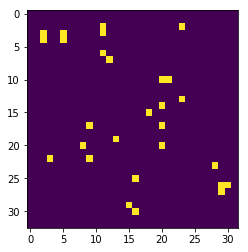

In [160]:
l2=thresholding(test_dat_2,30)
l1=thresholding(test_dat,30)

l2l=thresholding(test_dat_2,60)

tag_list=boxing(deepcopy(l2))

plt.imshow(l2)

In [214]:
import random

smin=0.25
smax=0.5

Amin=50
Amax=250

tmin=0
tmax=np.pi

def error(spe__array,dat_tag,input_dat=test_dat):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                #print(event.intensity_matrix.shape)
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

sample_length=40

def gradient_descent_single(input_dat,dat_tag):
    l=dat_tag.param()[0]
    r=dat_tag.param()[2]+1
    t=dat_tag.param()[1]
    b=dat_tag.param()[3]+1
    dat=input_dat[l:r,t:b]
    #return dat
    #print(dat)
    index=np.unravel_index(dat.argmax(),dat.shape)
    
    #return index
    
    x=l+index[0]+0.5
    y=t+index[1]+0.5
    print(dat)
    #s_x=random.uniform(smin,smax)
    #s_y=random.uniform(smin,smax)
    #A=random.uniform(Amin,Amax)
    
    s_x=0.4
    s_y=0.4
    #A=dat.max()
    A=23
    
    spe=gaussian_spe(y,x,s_x,s_y,A)
    print([x,y,s_x,s_y,A])
    #print(l,r,t,b)
    print(spe.intensity_matrix[l:r,t:b].astype(int))
    
    
    err=error([spe],dat_tag,test_dat_2)
    print(err)
    
    step_xy=0.02
    step_s=0.01
    step_A=1
    descent_factor=0.05
    
    err_array=[]
    
    print([x,y,s_x,s_y,A])
    for i in range(50):
        err=error([spe],dat_tag,test_dat_2)
        p_x=error([gaussian_spe(y,x+step_xy,s_x,s_y,A)],dat_tag,test_dat_2)-err
        p_y=error([gaussian_spe(y+step_xy,x,s_x,s_y,A)],dat_tag,test_dat_2)-err
        p_sx=error([gaussian_spe(y,x,s_x+step_s,s_y,A)],dat_tag,test_dat_2)-err
        p_sy=error([gaussian_spe(y,x,s_x,s_y+step_s,A)],dat_tag,test_dat_2)-err
        p_A=error([gaussian_spe(y,x,s_x,s_y,A+step_A)],dat_tag,test_dat_2)-err
        x=x-p_x*descent_factor*step_xy
        y=y-p_y*descent_factor*step_xy
        s_x=s_x-p_sx*descent_factor*step_s
        s_y=s_y-p_sy*descent_factor*step_s
        A=A-p_A*descent_factor*step_A
        spe=gaussian_spe(y,x,s_x,s_y,A)
        err_array.append(err)
        print([x,y,s_x,s_y,A])
    print(spe.intensity_matrix[l:r,t:b].astype(int))
    
    plt.plot(err_array)
    

[[ 4  5 -3]
 [-3 40 15]
 [ 5 26  7]]
[17.5, 9.5, 0.4, 0.4, 23]
[[ 1 12  1]
 [12 89  9]
 [ 1  9  0]]
3147.206684422171
[17.5, 9.5, 0.4, 0.4, 23]
[17.5598968039749, 9.545999913330114, 0.4734855781718966, 0.45714978668068107, 2.4826273309381577]
[17.563919394552784, 9.547984459997787, 0.4715540120377724, 0.4536376744116689, 14.78581821505071]
[17.59731189050368, 9.56848952035484, 0.48223857665474773, 0.4559928962083616, 12.576653505298925]
[17.62227342524533, 9.582175650499032, 0.4866012365490313, 0.4536409226295351, 13.571092519781898]
[17.6482395065802, 9.594062627879675, 0.4918190823975692, 0.45125933587969475, 13.735691112259572]
[17.672711277574216, 9.606950706441618, 0.4964194927252898, 0.44986668713327943, 14.029235386656968]
[17.69567019655549, 9.618918310536653, 0.5005535751638025, 0.44854557666979716, 14.309520664453395]
[17.712791659711606, 9.627980743378847, 0.5021753014960901, 0.44630475367331757, 14.548195484488287]
[17.732399582567307, 9.638091519094331, 0.5054919698152457,

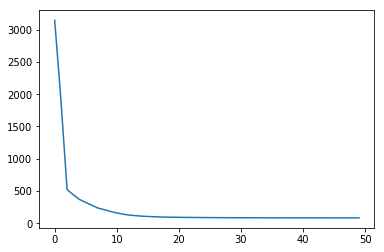

In [220]:
gradient_descent_single(test_dat_2,tag_list[8])